# ESM1 Plotting
The purpose of this notebook is to access the CMIP6 data sets and present the ESM1 temperature data from historic simulations. Dask functionality has been added to improve speed of calculations, and functions have been implements to reduce the number of cells that require running for different dates.

The [report findings](#Presentation-of-data) can be found in the bottom half of the document.

//Todo:<br>
worker memory error requires investigation<br>
<br>

#### Dask Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36208")
client

Client Scheduler: tcp://127.0.0.1:36208 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 5 Memory: 32.21 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Ocean Area data for averaging 
areaVariableId = 'areacello'
areaSourceId = 'CESM2'
areaDataSetNo = 0 #First database in results to be used

#Custom Variables
startTimeFull = '1850-01-16' #Start of full data set, included
endTimeFull = '2015-01-16' #End of full data set, excluded
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm

<br>

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

<br>

#### Filtering for relevant data sets
ESM3 data sets

In [5]:
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270900,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271411,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401311,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401333,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430508,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


Ocean area data to be used for averaging

In [6]:
dfArea = df[df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId)]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

73 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
58185,CMIP,NCAR,CESM2,historical,r6i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
58186,CMIP,NCAR,CESM2,historical,r6i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
58545,CMIP,NCAR,CESM2,historical,r5i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
58553,CMIP,NCAR,CESM2,historical,r5i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
58849,CMIP,NCAR,CESM2,historical,r4i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308


<br>

#### Opening all datafiles
ESM3 data

In [7]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

Ocean Area data

In [8]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
dataAreaRaw = dsArea.areacello

<br>

#### Combine data sets into one xarray

In [9]:
for i in range(fileCount): #Formatting dates into np.datetime64 format
    fileSetList[i]['time']=('time',np.arange(startTimeFull,endTimeFull,dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds',np.arange(startTimeFull,endTimeFull ,dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='SetId') #Combining data sets
#fileSet #Uncomment to see full data set

<br>

#### Selection of Data

In [10]:
dataFiltLatLev = fileSet.thetao.sel(lat=latSel, lev=5.0) #Selection of latitude and depth
dataFiltFull = dataFiltLatLev.reset_coords(drop=True) #Removes lev if single value
print("Finished data selection")
#dataFiltFull #Uncomment to see filtered data set

Finished data selection


<br>

#### Time identification

In [11]:
globalStartDate = dataFiltFull["time"][0].values
globalDateInc = dataFiltFull["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dataFiltFull["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data start date: "+globalStartDateStr)
print("Data end date (included): "+str(globalEndDateInStr))
print("Data end date (excluded): "+str(globalEndDateOutStr))
print("Data increments in steps of "+str(globalDateInc))

Data start date: 1850-01
Data end date (included): 2014-12
Data end date (excluded): 2015-01
Data increments in steps of 2678400000000000 nanoseconds


<br>

#### Calculation
Functions: <br>
meanTemp - Calculates the Southern Ocean mean temperature for a given data set <br>
dateCheck1 - Takes in a single date and checks to see if it is inside the data set. If not then the nearest valid date is returned<br>
dateCheck2 - Takes in a pair of dates (start and end) and checks to see if they are ordered correctly (start before end) and that both dates are inside the data set. If not then the nearest valid dates are returned<br>
singleSoloDateCalc - Calculates and displays the Ocean temperature at all locations from a selected data set,  prints mean ocean temperature <br>
singleAllDateCalc - Calculates and displays the Ocean temperature at all locations from all data sets,  prints mean ocean temperature <br>
rangeSoloCompareCalc - Calculates and displays the change in ocean temperature between two dates for a selected data set, prints mean ocean temperature and change<br>
rangeAllCompareCalc - Calculates and displays the change in ocean temperature between two dates for all data sets, prints mean ocean temperature and change<br>
rangeSoloDateCalc - Calculates and displays the mean Ocean temperature as a line plot for a given time period from a selected data set <br>
rangeAllDateCalc - Calculates and displays the mean Ocean temperature as a line plot for a given time period from all data sets, can also show standard deviation for data <br>

Global Data: <br>
dataAreaSH - Ocean area data for the selected latitudes ([latSec](#Choices-for-data)), taken from first [areacello](#Accessing-Dataset-Database) database <br>
totalArea - The sum of all the area in dataAreaSH ([see above](#Calculation))

In [12]:
@delayed
def meanTemp(dataSet):
    '''Calculates and returns Mean Ocean temperature for a given data set. Requires global dataAreaSH, totalArea'''
    return (dataSet*dataAreaSH).sum(dim=['lon', 'lat']) / totalArea 

dataAreaSH = dataAreaRaw.sel(lat=latSel) #Selecting data for relevant latittude
totalArea = dataAreaSH.sum(dim=['lon', 'lat']) #Summing selected area

def dateCheck1(Date):
    '''Takes date input, check to ensure that date is valid for the data set, modifying it if not. Requires global globalStartDate, globalEndDate, globalStartDateStr, globalEndDateStr'''
    if np.datetime64(Date ,'M') < globalStartDate:
        Date = globalStartDateStr
    elif np.datetime64(Date ,'M') > globalEndDateOut:
        Date = globalEndDateInStr
    return Date

def dateCheck2(startDate, endDate):
    '''Takes start and end date input, check to ensure that both dates are valid for the data set, modifying them if not. Requires global globalStartDate, globalEndDate, globalStartDateStr, globalEndDateStr'''
    if np.datetime64(startDate ,'M') > np.datetime64(endDate ,'M'):
        startDate, endDate = endDate, startDate
    if np.datetime64(startDate ,'M') < globalStartDate:
        startDate = globalStartDateStr
        if np.datetime64(endDate ,'M') < globalStartDate:
            endDate = globalStartDateStr
    if np.datetime64(endDate ,'M') > globalEndDateOut:
        endDate = globalEndDateOutStr
        if np.datetime64(startDate ,'M') > globalEndDateOut:
            startDate = globalEndDateInStr
    return startDate, endDate

def singleSoloDateCalc(date,setId,plotNo):
    '''Calculates and displays Ocean temperature for a selected date, prints mean ocean temperature, uses only 1 data set. Requires global dataFiltFull, dataAreaSH, totalArea'''
    singleData = dataFiltFull.sel(SetId=setId, time=date)
    singleTemp = meanTemp(singleData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(singleData,date, valuesSingleTemp, setId, plotNo)
    
def singleAllDateCalc(date, stdBool, plotNo):
    '''Calculates and displays Ocean temperature for a selected date, prints mean ocean temperature, averages all data sets. Requires global dataFiltFull, dataAreaSH, totalArea'''
    multiData = dataFiltFull.sel(time=date)
    meanData = multiData.mean("SetId", keep_attrs =True)
    meanData.compute()
    multiTemps = meanTemp(multiData)
    valuesMultiTemps = multiTemps.compute()
    valuesMeanTemp = valuesMultiTemps.mean("SetId")
    valuesMeanTemp.compute()
    singleTimePlot(meanData, date, valuesMeanTemp, "All", plotNo)
    if stdBool:
        stdData = multiData.std("SetId", keep_attrs =True)
        stdData.compute()
        valuesStdTemp = stdData.mean(["lon", "lat"])
        valuesStdTemp.compute()
        singleTimePlotStd(stdData, date, valuesStdTemp, plotNo+1)

def rangeSoloCompareCalc(startDate, endDate, setId, plotNo):
    '''Calculates and displays change in Ocean temperature for two dates for a given data set, prints mean ocean temperature at both time dates and the difference. Requires global dataFiltFull, dataAreaSH, totalArea'''
    startData = dataFiltFull.sel(SetId=setId, time=startDate)
    endData = dataFiltFull.sel(SetId=setId, time=endDate)
    diffData = startData
    diffData.values = (endData.values - startData.values)
    singleTemp = meanTemp(diffData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(diffData,endDate+" vs "+startDate, valuesSingleTemp, setId, plotNo)
    
def rangeAllCompareCalc(startDate, endDate, stdBool, plotNo):
    '''Calculates and displays change in Ocean temperature for two dates for a given data set, prints mean ocean temperature at both time dates and the difference. Requires global dataFiltFull, dataAreaSH, totalArea'''
    startData = dataFiltFull.sel(time=startDate)
    endData = dataFiltFull.sel(time=endDate)
    diffData = startData
    diffData.values = (endData.values - startData.values)
    meanDiffData = diffData.mean("SetId", keep_attrs =True)
    meanDiffData.compute()
    singleTemp = meanTemp(meanDiffData)
    valuesSingleTemp = singleTemp.compute()
    singleTimePlot(meanDiffData,endDate+" vs "+startDate, valuesSingleTemp, "All", plotNo)
    if stdBool:
        stdData = diffData.std("SetId", keep_attrs =True)
        stdData.compute()
        valuesStdTemp = stdData.mean(["lon", "lat"])
        valuesStdTemp.compute()
        singleTimePlotStd(stdData, endDate+" vs "+startDate, valuesStdTemp, plotNo+1)
    
def rangeSoloDateCalc(startDate, endDate, setId, plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses only 1 data set. Requires global dataFiltFull, dataAreaSH, totalArea'''
    startDate, endDate = dateCheck2(startDate, endDate)
    multiData = dataFiltFull.sel(SetId=setId, time=slice(startDate, endDate))
    multiTemp = meanTemp(multiData)
    valuesMultiTemp = multiTemp.compute()
    multiTimePlot(valuesMultiTemp, startDate, endDate, setId, plotNo)

def rangeAllDateCalc(startDate, endDate, stdBool , plotNo):
    '''Calculates and displays Ocean temperature for a time period, prints mean ocean temperature, uses only 1 data set. Requires global dataFiltFull, dataAreaSH, totalArea'''
    startDate, endDate = dateCheck2(startDate, endDate)
    multiDatas = dataFiltFull.sel(time=slice(startDate, endDate))
    multiTemps = meanTemp(multiDatas)
    valuesMultiTemps = multiTemps.compute()
    meanMultiTemp = valuesMultiTemps.mean("SetId", keep_attrs =True)
    meanMultiTemp.compute()
    multiTimePlot(meanMultiTemp, startDate, endDate, 'All', plotNo)
    if stdBool:
        stdMultiTemp = valuesMultiTemps.std("SetId", keep_attrs =True)
        stdMultiTemp.compute()
        multiTimePlotStd(stdMultiTemp, startDate, endDate, plotNo + 1)

<br>

#### Presentation of data
Functions: <br>
singleTimePlot - Displays the Ocean temperature at all locations from a given data set, prints mean ocean temperature. <br>
singleTimePlotStd - Displays the Ocean temperature standard deviation at all locations from a given data set, prints mean ocean temperature standard deviation. <br>
multiTimePlot - Displays the mean Ocean temperature from a given data set as a line plot <br>
multiTimePlotStd - Displays the standard deviation of Ocean temperature from a given data set as a line plot <br>

In [13]:
def singleTimePlot(dataSet, date, meanTempArray, setStr, plotNo):
    '''Displays Ocean temperature for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo)
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp - " + str(date) + " ("+str(setStr)+")")
    print("Average Ocean temperature for plot "+str(plotNo)+" ("+date+")(Set "+str(setStr)+"): "+str(round(meanTempArray.values[0],3))+" Celsius")
    
def singleTimePlotStd(dataSet, date, stdTempArray, plotNo):
    '''Displays Ocean temperature standard deviation for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo)
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title("Southern Ocean Temp Std - " + str(date))
    print("Average Ocean temperature standard deviation for plot "+str(plotNo)+" ("+date+"): "+str(round(stdTempArray.values[0],3))+" Celsius")
    
def multiTimePlot(dataSet, startDate, endDate, setStr, plotNo):
    '''Displays Ocean temperature for given data set as line graph'''
    plt.figure(plotNo)
    dataSet.plot(label='Monthly Mean')
    if np.datetime64(startDate,'M') < (np.datetime64(endDate,'M') + np.timedelta64(12,'M')): #Check to ensure there is sufficent range in the data set for rolling average
        dataSetRollingMean = dataSet.rolling(time=12).mean()
        dataSetRollingMean.plot(label='12 month rolling mean')
        print("Mean Annual rolling Temp on "+str(np.datetime64(startDate,'M')+np.timedelta64(11, 'M'))+": "+str(round(dataSetRollingMean.values[11], 3))+" Celcius")
        print("Mean Annual rolling Temp on "+str(endDate)+": "+str(round(dataSetRollingMean.values[-1],3))+" Celcius")
        print("Mean Annual rolling Temp increase: "+str(round(dataSetRollingMean.values[-1] - dataSetRollingMean.values[11],4))+" Celcius")
    plt.legend()
    plt.title("Southern Ocean Temp - " + str(startDate)+" to "+str(endDate))
    
def multiTimePlotStd(dataSet, startDate, endDate, plotNo):
    '''Displays Ocean temperature standard devation for given data set as line graph'''
    plt.figure(plotNo)
    dataSet.plot(label='Monthly Std')
    plt.legend()
    plt.title("Southern Ocean Temp Deviation - " + str(startDate)+" to "+str(endDate)+" ("+str(fileCount)+" datasets)")

# TEST REQUIRED

Mean Annual rolling Temp on 2005-11: 8.69 Celcius
Mean Annual rolling Temp on 2007-12: 8.664 Celcius
Mean Annual rolling Temp increase: -0.0254 Celcius


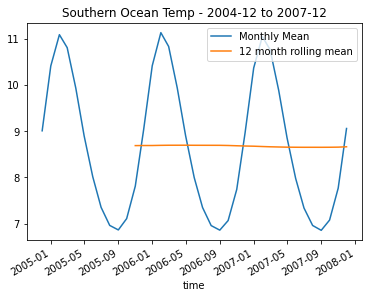

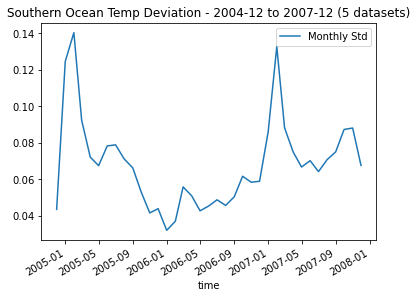

In [14]:
rangeAllDateCalc('2004-12','2007-12', True, 1)

# END

Comparison of Southern Ocean Temperature from start of time frame with end

Average Ocean temperature for plot 1 (2005-01)(Set All): 10.413 Celsius
Average Ocean temperature standard deviation for plot 2 (2005-01): 0.546 Celsius
Average Ocean temperature for plot 3 (2014-12)(Set All): 9.217 Celsius
Average Ocean temperature standard deviation for plot 4 (2014-12): 0.45 Celsius


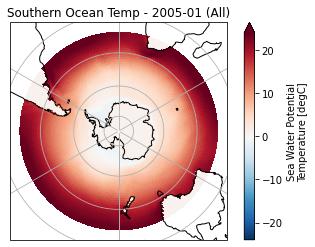

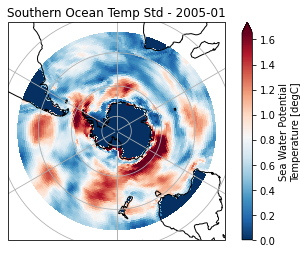

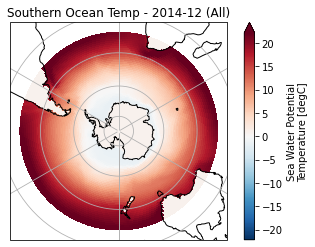

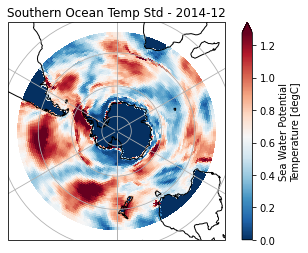

In [15]:
singleAllDateCalc('2005-01', True, 1)
singleAllDateCalc('2014-12', True, 3)

<br>
Comparison of Dec 2004 to Dec 2014, averaged across all data sets

Average Ocean temperature for plot 1 (2014-12 vs 2004-12)(Set All): 0.207 Celsius
Average Ocean temperature standard deviation for plot 2 (2014-12 vs 2004-12): 0.664 Celsius


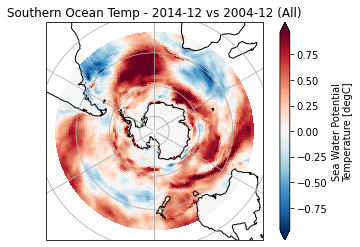

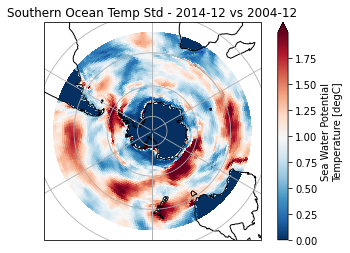

In [16]:
rangeAllCompareCalc('2004-12', '2014-12', True, 1)

Average Ocean temperature for plot 0 (2014-12 vs 2004-12)(Set 0): 0.181 Celsius
Average Ocean temperature for plot 1 (2014-12 vs 2004-12)(Set 1): 0.016 Celsius
Average Ocean temperature for plot 2 (2014-12 vs 2004-12)(Set 2): 0.243 Celsius
Average Ocean temperature for plot 3 (2014-12 vs 2004-12)(Set 3): 0.228 Celsius
Average Ocean temperature for plot 4 (2014-12 vs 2004-12)(Set 4): 0.369 Celsius


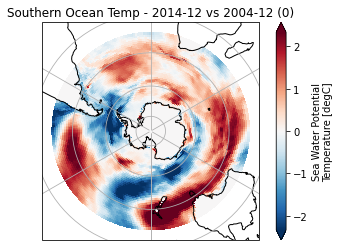

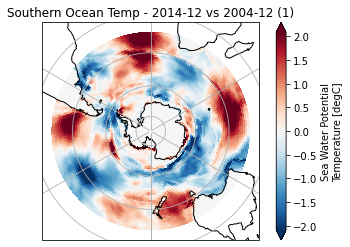

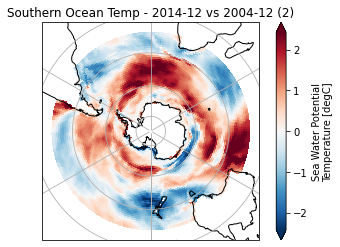

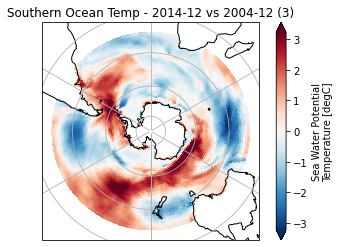

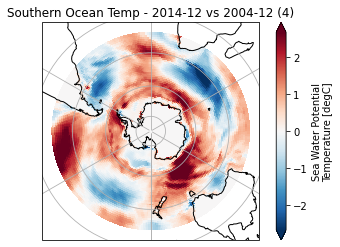

In [17]:
for i in range(fileCount):
    rangeSoloCompareCalc('2004-12', '2014-12', i, i)

Average Ocean temperature for plot 3 (2014-12 vs 2004-12)(Set 0): 0.181 Celsius
Average Ocean temperature for plot 2 (2004-12)(Set 0): 9.014 Celsius
Average Ocean temperature for plot 1 (2014-12)(Set 0): 9.196 Celsius


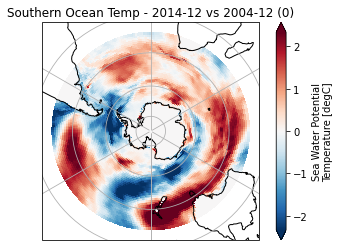

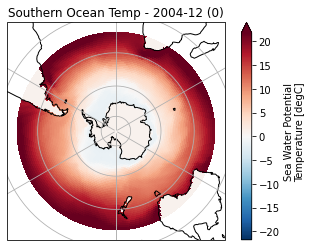

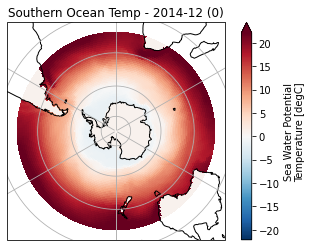

In [18]:
rangeSoloCompareCalc('2004-12', '2014-12', 0, 3)
singleSoloDateCalc('2004-12', 0 ,2)
singleSoloDateCalc('2014-12', 0 ,1)

Comparison of Average Southern Ocean Temperature across the time frame

Mean Annual rolling Temp on 2005-11: 8.69 Celcius
Mean Annual rolling Temp on 2014-12: 8.902 Celcius
Mean Annual rolling Temp increase: 0.2117 Celcius


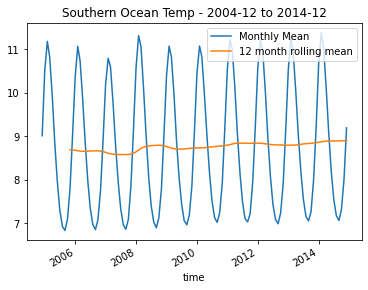

In [19]:
rangeSoloDateCalc('2004-12', '2014-12', 0, 1) 